In [ ]:
#Importing the necessary libraries

import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
import hdbscan
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

In [81]:
data = pd.read_csv("../Datasets/online_retail_II.csv", parse_dates = ['InvoiceDate'])

In [82]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [3]:
data.rename(columns={
    "Invoice": "InvoiceNo",
    "Price": "UnitPrice",
    "Customer ID": "CustomerID"
}, inplace=True)

In [4]:
#Printing the info, and head of the dataset

print(data.info())

print(f"\n The first few rows of the dataset are: \n{data.head()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   InvoiceNo    1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   UnitPrice    1067371 non-null  float64       
 6   CustomerID   824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB
None

 The first few rows of the dataset are: 
  InvoiceNo StockCode                          Description  Quantity  \
0    489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1    489434    79323P                   PINK CHERRY LIGHTS        12   
2    489434    79323W            

Exploring the dataset

In [5]:
print(f"Shape of the dataset: {data.shape}")
print(f"\nMissing values: \n{data.isnull().sum()}")
print(f"\nDuplicate values are: \n{data.duplicated().sum()}")
print(f"\nStats of the dataset: \n{data.describe()}")

Shape of the dataset: (1067371, 8)

Missing values: 
InvoiceNo           0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     243007
Country             0
dtype: int64

Duplicate values are: 
34335

Stats of the dataset: 
           Quantity                    InvoiceDate     UnitPrice  \
count  1.067371e+06                        1067371  1.067371e+06   
mean   9.938898e+00  2011-01-02 21:13:55.394028544  4.649388e+00   
min   -8.099500e+04            2009-12-01 07:45:00 -5.359436e+04   
25%    1.000000e+00            2010-07-09 09:46:00  1.250000e+00   
50%    3.000000e+00            2010-12-07 15:28:00  2.100000e+00   
75%    1.000000e+01            2011-07-22 10:23:00  4.150000e+00   
max    8.099500e+04            2011-12-09 12:50:00  3.897000e+04   
std    1.727058e+02                            NaN  1.235531e+02   

          CustomerID  
count  824364.000000  
mean    15324.638504  
min     12346.000000  

Dealing with missing values

In [6]:
#Removing NaN's in Customer ID

print("Shape of data before removing Nan's CustomerID", data.CustomerID.isnull().sum())

data.dropna(subset = "CustomerID", axis=0, inplace=True)

print("Shape of data after removing Nan's CustomerID", data.CustomerID.isnull().sum())

Shape of data before removing Nan's CustomerID 243007
Shape of data after removing Nan's CustomerID 0


In [7]:
#Printing the missing values of each column again


print(f"Missing values in each column are:\n{data.isnull().sum()}")


Missing values in each column are:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


Since removing the null values in CustomerID also automatically handled the null values in Description column too, we  are good to move onto the next step.

Removing Duplicates

In [8]:
print(f"Number of duplicates before cleaning:\n{data.duplicated().sum()}")

data = data.drop_duplicates(keep='first')

print(f"Number of duplicates after cleaning:\n{data.duplicated().sum()}")

Number of duplicates before cleaning:
26479
Number of duplicates after cleaning:
0


Cleaning Outliers

In [9]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

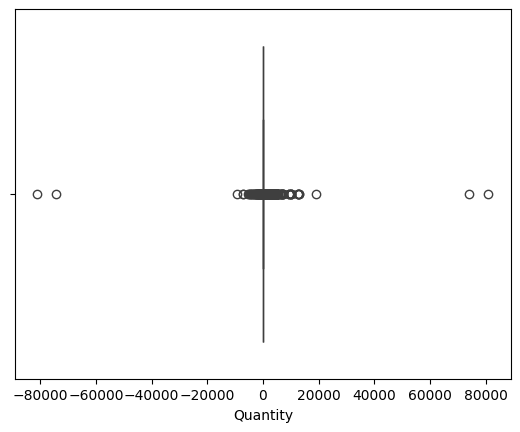

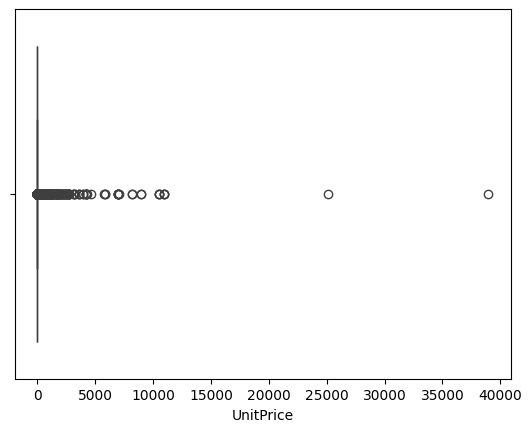

In [10]:
#Visualizing the Outlier

sns.boxplot(x=data["Quantity"])
plt.show()

sns.boxplot(x=data["UnitPrice"])
plt.show()

In [11]:
#Removing the outliers

replace_with_threshold(data, "Quantity")
replace_with_threshold(data, "UnitPrice")

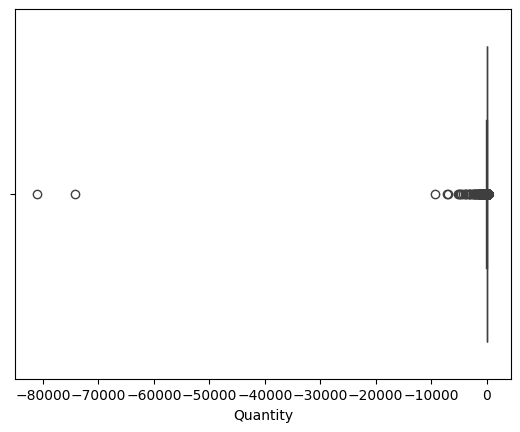

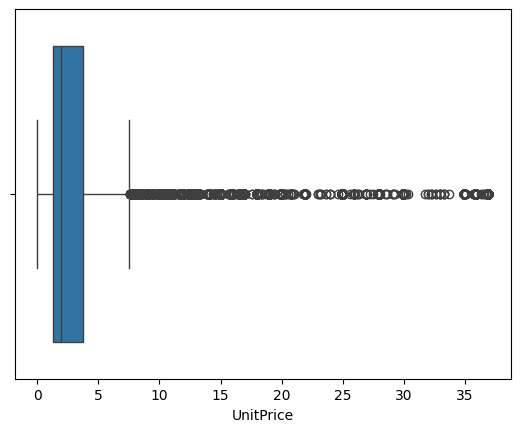

In [12]:
#Visualizing the Outlier

sns.boxplot(x=data["Quantity"])
plt.show()

sns.boxplot(x=data["UnitPrice"])
plt.show()

Feature Engineering

Removing cancelled InvoiceNumbers from invoice

In [13]:
data = data[~data["InvoiceNo"].str.contains('C',na=False)]
print("Dataset is free from cancelled products information")

Dataset is free from cancelled products information


Creating New RFM Columns

In [14]:
data["Revenue"] = data["Quantity"] * data["UnitPrice"]

In [15]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
count,779495.000000,779495,779495.000000,779495.000000,779495.000000
mean,12.024193,2011-01-03 01:46:36.061116416,2.954198,15320.262918,20.881923
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000,0.000000
25%,2.000000,2010-07-02 14:39:00,1.250000,13971.000000,4.950000
50%,6.000000,2010-12-02 14:09:00,1.950000,15246.000000,12.480000
75%,12.000000,2011-08-01 13:48:00,3.750000,16794.000000,19.800000
max,323.000000,2011-12-09 12:50:00,36.940000,18287.000000,3884.000000
std,27.177937,NaN,3.250003,1695.722988,52.045338


In [16]:
Latest_Date = data["InvoiceDate"].max()
print(Latest_Date)

2011-12-09 12:50:00


In [ ]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (Latest_Date - x.max()).days,
    'InvoiceNo': lambda x: x.nunique(),
    'Quantity' : lambda x: x.sum(),
    "Revenue" : lambda x: x.sum()
})

In [18]:
rfm.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency',
                         'Quantity': 'TotalQuantity', 
                         'Revenue': 'Monetary'}, inplace=True)

In [19]:
rfm

,Recency,Frequency,TotalQuantity,Monetary
CustomerID,,,,
12346.0,325,12,393,708.78
12347.0,1,8,2967,4921.53
12348.0,74,5,2714,1991.86
12349.0,18,4,1624,3786.50
12350.0,309,1,197,331.34
...,...,...,...,...
18283.0,3,22,1679,2664.90
18284.0,431,1,494,448.62
18285.0,660,1,145,413.94


In [20]:
rfm['AvgBasketSize'] = rfm['TotalQuantity'] / rfm['Frequency']
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

Adding a new feature in the RFM Analysis, Interpurchase-Time.

Interpurchase Time calculates the average time gap between total shopping trips by a customer.

In [21]:
rfm = rfm[(rfm["Frequency"]>1)] # Since this feature is only for regular customers

In [22]:
cycle = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: ((x.max() - x.min()).days)
})

In [23]:
rfm["Shopping_Cycle"] = cycle

C:\Users\akw97\AppData\Local\Temp\ipykernel_21436\1615391809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["Shopping_Cycle"] = cycle


In [24]:
rfm["Interpurchase_time"] = rfm["Shopping_Cycle"] // rfm["Frequency"]
rfmt = rfm[["Recency","Frequency","Monetary","Interpurchase_time", "AvgBasketSize", "AvgOrderValue"]]
rfmt.head()

C:\Users\akw97\AppData\Local\Temp\ipykernel_21436\220487535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["Interpurchase_time"] = rfm["Shopping_Cycle"] // rfm["Frequency"]


,Recency,Frequency,Monetary,Interpurchase_time,AvgBasketSize,AvgOrderValue
CustomerID,,,,,,
12346.0,325,12,708.78,33,32.750,59.06500
12347.0,1,8,4921.53,50,370.875,615.19125
12348.0,74,5,1991.86,72,542.800,398.37200
12349.0,18,4,3786.50,142,406.000,946.62500
12352.0,35,10,2098.94,35,72.400,209.89400


Which Clustering Algorithm to choose?

In [25]:
# Dictionary to store results
results = {}

# 1. K-Means
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
labels_kmeans = kmeans.fit_predict(rfmt)
results['KMeans'] = {
    'labels': labels_kmeans,
    'silhouette': silhouette_score(rfmt, labels_kmeans),
    'dbi': davies_bouldin_score(rfmt, labels_kmeans)
}

# 2. Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)
labels_gmm = gmm.fit_predict(rfmt)
results['GMM'] = {
    'labels': labels_gmm,
    'silhouette': silhouette_score(rfmt, labels_gmm),
    'dbi': davies_bouldin_score(rfmt, labels_gmm)
}

# 3. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(rfmt)
results['DBSCAN'] = {
    'labels': labels_dbscan,
    'silhouette': "N/A (1 cluster or noise only)",
    'dbi': "N/A"
}

# 4. HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=30)
labels_hdbscan = clusterer.fit_predict(rfmt)
if len(set(labels_hdbscan)) > 1 and -1 in set(labels_hdbscan):
    valid_labels = labels_hdbscan[labels_hdbscan != -1]
    valid_pca = rfmt[labels_hdbscan != -1]
    results['HDBSCAN'] = {
        'labels': labels_hdbscan,
        'silhouette': silhouette_score(valid_pca, valid_labels),
        'dbi': davies_bouldin_score(valid_pca, valid_labels)
    }
else:
    results['HDBSCAN'] = {
        'labels': labels_hdbscan,
        'silhouette': "N/A",
        'dbi': "N/A"
    }

# Print results
for method, metrics in results.items():
    print(f"\n--- {method} ---")
    print(f"Silhouette Score: {metrics['silhouette']}")
    print(f"Davies-Bouldin Index: {metrics['dbi']}")



--- KMeans ---
Silhouette Score: 0.8031551557672297
Davies-Bouldin Index: 0.45521178433750575

--- GMM ---
Silhouette Score: 0.4784822875907569
Davies-Bouldin Index: 0.7667086415218158

--- DBSCAN ---
Silhouette Score: N/A (1 cluster or noise only)
Davies-Bouldin Index: N/A

--- HDBSCAN ---
Silhouette Score: 0.7431296855644746
Davies-Bouldin Index: 0.19302192493548584



KMeans Cluster Counts:
0    3905
1       2
2       7
3      27
4     314
Name: count, dtype: int64


C:\Users\akw97\AppData\Local\Temp\ipykernel_21436\4176551836.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set3")


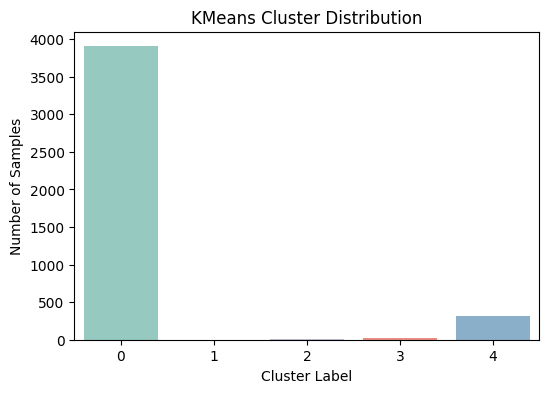

C:\Users\akw97\AppData\Local\Temp\ipykernel_21436\4176551836.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set3")



GMM Cluster Counts:
0    2690
1       2
2     173
3    1390
Name: count, dtype: int64


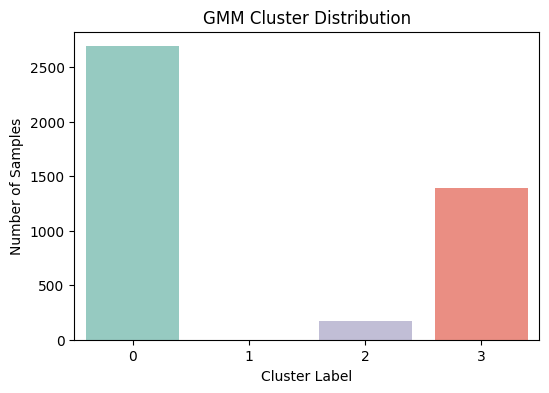


DBSCAN Cluster Counts:
-1    4255
Name: count, dtype: int64


C:\Users\akw97\AppData\Local\Temp\ipykernel_21436\4176551836.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set3")


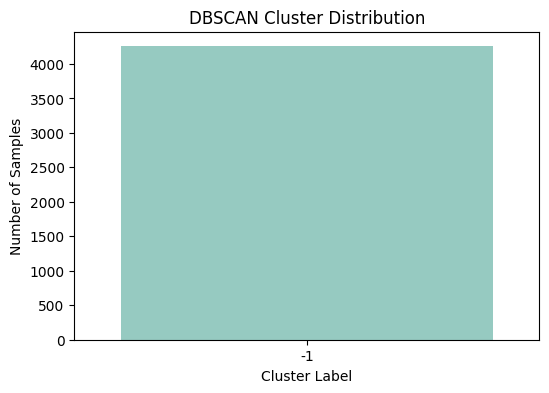

C:\Users\akw97\AppData\Local\Temp\ipykernel_21436\4176551836.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set3")



HDBSCAN Cluster Counts:
-1     235
 0    3990
 1      30
Name: count, dtype: int64


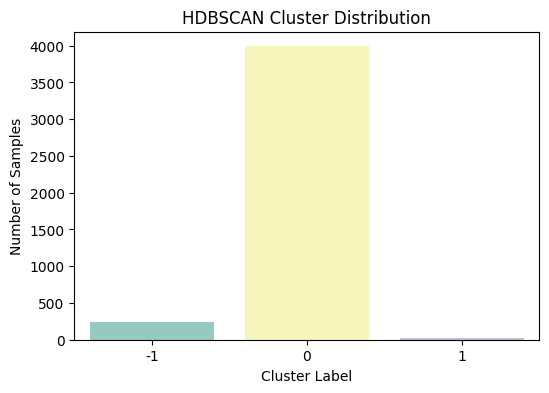

In [26]:
def plot_cluster_distribution(labels, title):
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    print(f"\n{title} Cluster Counts:\n{cluster_counts}")

    plt.figure(figsize=(6,4))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set3")
    plt.title(f"{title} Cluster Distribution")
    plt.xlabel("Cluster Label")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=0)
    plt.show()

# KMeans
plot_cluster_distribution(results['KMeans']['labels'], "KMeans")

# GMM
plot_cluster_distribution(results['GMM']['labels'], "GMM")

# DBSCAN
plot_cluster_distribution(results['DBSCAN']['labels'], "DBSCAN")

# HDBSCAN
plot_cluster_distribution(results['HDBSCAN']['labels'], "HDBSCAN")

We will use K-means Clustering to cluster the different customer groups

Using Elbow Method for finding the optimal K values

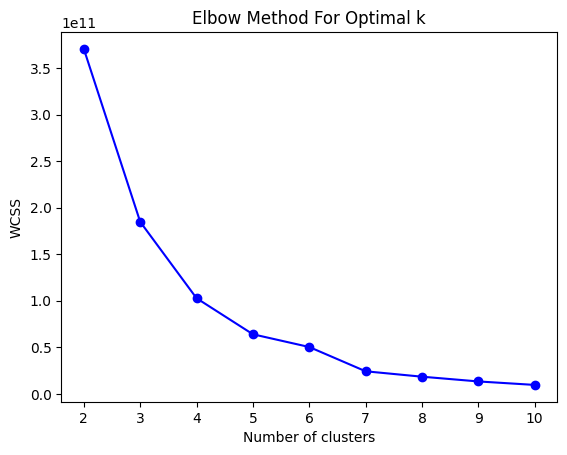

In [27]:
#Elbow Method to choose the optimal number of clusters

wcss = []
k_range = range(2, 11)
for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfmt)
    wcss.append(kmeans.inertia_)

#Visualizing the results

plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

Therefore, we will use 5 as our optimal K value

C:\Users\akw97\AppData\Local\Temp\ipykernel_21436\921623665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfmt['Cluster'] = kmeans.fit_predict(rfmt) #Assigning the cluster labels to the original dataframe


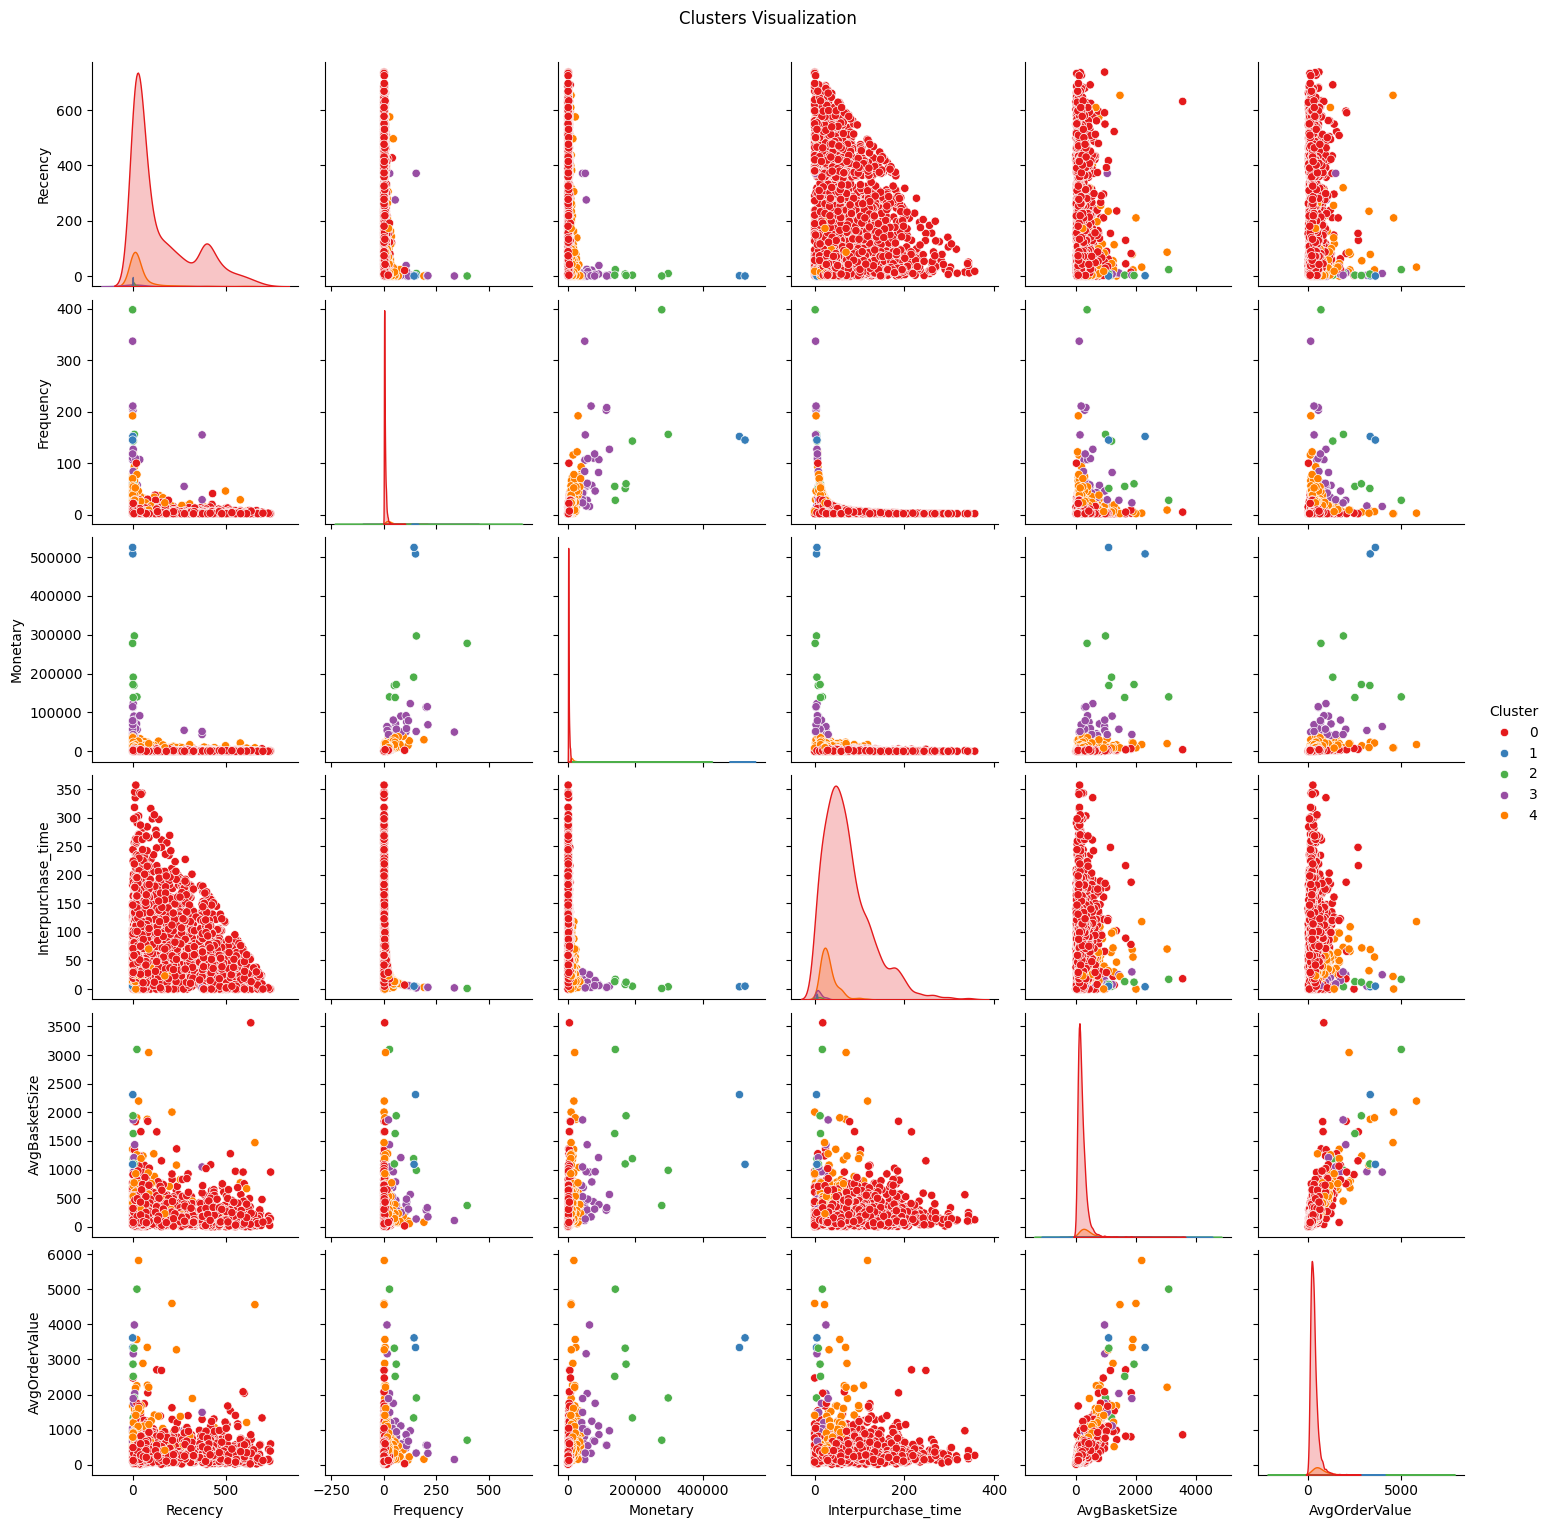

In [28]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=50)
rfmt['Cluster'] = kmeans.fit_predict(rfmt) #Assigning the cluster labels to the original dataframe

#Visualizing the clusters
sns.pairplot(rfmt, hue='Cluster', palette='Set1', diag_kind='kde')
plt.suptitle('Clusters Visualization', y=1.02)
plt.show()

In [29]:
rfmt["Cluster"].value_counts()

Cluster
0    3905
4     314
3      27
2       7
1       2
Name: count, dtype: int64

In [30]:
silscore = silhouette_score(rfmt, rfmt['Cluster'])
print(f"Silhouette Score: {silscore:.2f}")

davidscore = davies_bouldin_score(rfmt, rfmt['Cluster'])
print(f"David Bouldin Score: {davidscore:.2f}")

Silhouette Score: 0.80
David Bouldin Score: 0.46


In [31]:
rfmt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4255 entries, 12346.0 to 18287.0
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Recency             4255 non-null   int64  
 1   Frequency           4255 non-null   int64  
 2   Monetary            4255 non-null   float64
 3   Interpurchase_time  4255 non-null   int64  
 4   AvgBasketSize       4255 non-null   float64
 5   AvgOrderValue       4255 non-null   float64
 6   Cluster             4255 non-null   int32  
dtypes: float64(3), int32(1), int64(3)
memory usage: 249.3 KB


Labelling the Clusters

In [34]:
# Looing at the average values in each cluster
rfmt['Cluster'] = kmeans.labels_  # or your chosen algorithm

cluster_summary = rfmt.groupby('Cluster').mean().round(2)
cluster_summary

C:\Users\akw97\AppData\Local\Temp\ipykernel_21436\1263178182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfmt['Cluster'] = kmeans.labels_  # or your chosen algorithm


,Recency,Frequency,Monetary,Interpurchase_time,AvgBasketSize,AvgOrderValue
Cluster,,,,,,
0,150.78,5.90,1827.69,72.55,191.36,319.50
1,0.50,148.50,516285.26,4.50,1699.16,3479.92
2,6.71,127.29,197960.12,8.57,1472.60,2521.49
3,43.63,93.59,65651.16,10.37,610.62,1122.41
4,40.50,27.31,14114.35,30.41,387.36,708.76


In [66]:
label_map = {
    0: "Medium-Spenders",
    1: "Top VIP Customers",
    2: "High-Value Regulars",
    3: "Established Mid-Tier",
    4: "Occasional Shoppers"
}

rfmt["Cluster_Label"] = rfmt["Cluster"].map(label_map)

In [67]:
rfmt

,Recency,Frequency,Monetary,Interpurchase_time,AvgBasketSize,AvgOrderValue,Cluster,Cluster_Label
CustomerID,,,,,,,,
12346.0,325,12,708.78,33,32.750000,59.065000,0,Medium-Spenders
12347.0,1,8,4921.53,50,370.875000,615.191250,0,Medium-Spenders
12348.0,74,5,1991.86,72,542.800000,398.372000,0,Medium-Spenders
12349.0,18,4,3786.50,142,406.000000,946.625000,0,Medium-Spenders
12352.0,35,10,2098.94,35,72.400000,209.894000,0,Medium-Spenders
...,...,...,...,...,...,...,...,...
18281.0,180,2,201.14,198,73.000000,100.570000,0,Medium-Spenders
18282.0,7,2,178.05,59,51.500000,89.025000,0,Medium-Spenders
18283.0,3,22,2664.90,29,76.318182,121.131818,0,Medium-Spenders


Now that we have our Clusters, we will use Random Forest Classifier.

In [73]:
X = rfmt.drop("Cluster_Label", axis=1)
y = rfmt["Cluster_Label"]


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.2, random_state=42)

In [75]:
# Adjust k_neighbors to avoid the ValueError
X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_resample(X_train, y_train)


In [76]:
y_resampled.value_counts()


Cluster_Label
Medium-Spenders         3124
Occasional Shoppers     3124
High-Value Regulars     3124
Established Mid-Tier    3124
Top VIP Customers       3124
Name: count, dtype: int64

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))  # Random Forest Classifier
])

# Fit the pipeline on the training data
pipeline.fit(X_resampled, y_resampled)

# Evaluate the pipeline on the test data
accuracy = pipeline.score(X_test, y_test)
print(f"Accuracy of the pipeline: {accuracy*100}") 

# Classification Report

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate predictions
y_pred = pipeline.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Accuracy of the pipeline: 100.0
Classification Report:
                      precision    recall  f1-score   support

Established Mid-Tier       1.00      1.00      1.00         6
 High-Value Regulars       1.00      1.00      1.00         1
     Medium-Spenders       1.00      1.00      1.00       781
 Occasional Shoppers       1.00      1.00      1.00        63

            accuracy                           1.00       851
           macro avg       1.00      1.00      1.00       851
        weighted avg       1.00      1.00      1.00       851

Confusion Matrix:
[[  6   0   0   0]
 [  0   1   0   0]
 [  0   0 781   0]
 [  0   0   0  63]]
